# **1. Import packages**

In [2]:
%%capture
!pip install torchmetrics
!pip install torchinfo

# **2. Import libraries**

In [3]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Preprocessing
import cv2
from sklearn.model_selection import train_test_split

# Torch
import torch
from torch import nn,optim
from torchmetrics.classification import MulticlassAccuracy
from torchinfo import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Model
from torchvision.models import resnet50

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# random
import random

# typing
from typing import Dict,List

# Warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **3. Load data and Preprocessing**

In [6]:
classes = os.listdir("/kaggle/input/endoscopic-bladder-tissue-classification-dataset/EndoscopicBladderTissue")
classes.remove("annotations.csv")
classes

['NTL', 'LGC', 'NST', 'HGC']

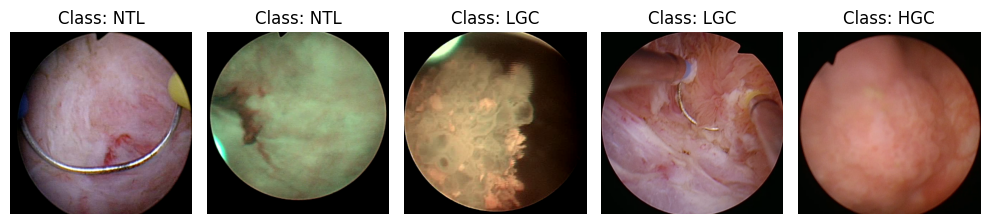

In [7]:
images_path = Path("/kaggle/input/endoscopic-bladder-tissue-classification-dataset/EndoscopicBladderTissue")

images_path_list = list(images_path.glob("*/*.png"))
TOTAL_IMAGES_TO_VIEW = 5
images_path_selected = random.choices(images_path_list, k = TOTAL_IMAGES_TO_VIEW)

fig,ax = plt.subplots(nrows = 1, ncols = TOTAL_IMAGES_TO_VIEW, figsize = (10,4))
ax = ax.flat

for i,img_path in enumerate(images_path_selected):
    img_BGR = cv2.imread(str(img_path))
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img_RGB)
    ax[i].set_title(f"Class: {img_path.parent.stem}")
    ax[i].axis("off")
    
fig.tight_layout()
fig.show()

In [8]:
# How many images do we have in total?
total_images = len(images_path_list)
total_images

1754

In [9]:
# We create a dictionary to store the paths of the images and their respective class.
images_dict = {"image_path":[], "classes":[]}

# Iterate over the list we have created where all the routes to capture are located
# its respective route and class.
for image_path in images_path_list:
  images_dict["image_path"].append(image_path)
  images_dict["classes"].append(image_path.parent.stem)

In [10]:
# We convert the dictionary we have created into a pd.DataFrame.
df_path_images_classes = pd.DataFrame(images_dict)
df_path_images_classes.head()

,image_path,classes
0,/kaggle/input/endoscopic-bladder-tissue-classi...,NTL
1,/kaggle/input/endoscopic-bladder-tissue-classi...,NTL
2,/kaggle/input/endoscopic-bladder-tissue-classi...,NTL
3,/kaggle/input/endoscopic-bladder-tissue-classi...,NTL
4,/kaggle/input/endoscopic-bladder-tissue-classi...,NTL


In [11]:
# Transformations that will be done to the images found in the training set.
train_transforms = transforms.Compose([
    transforms.Resize((128,128)), 
    transforms.TrivialAugmentWide(num_magnitude_bins = 31), 
    transforms.ToTensor()])

# Transformations that are done to the images in the test set.
test_transforms = transforms.Compose([
    transforms.Resize((128,128)), 
    transforms.ToTensor()])

In [12]:
# We separate the paths of the images from their respective label and then perform the division
# in training and testing.
X = df_path_images_classes.drop("classes", axis = 1)
y = df_path_images_classes["classes"]

In [13]:
# We perform the partition into training and test set.
# We will use stratify to maintain the proportion of classes.
# We define our random seed for reproducibility
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = SEED, 
                                                    stratify = y)

In [14]:
# We apply a mapping to our labels converting them into a number, then to an array
# and finally to a tensor.

label_map = {'HGC':0, 'LGC':0, 'NST':1, 'NTL':1}
id2label = {0:'HGC', 0:'LGC', 1:'NST', 1:'NTL'}

y_train = np.array(y_train.map(label_map))
y_train = torch.tensor(y_train)

y_test = np.array(y_test.map(label_map))
y_test = torch.tensor(y_test)

In [16]:
# We apply the transformations to our training set.
images_train = [None]*len(X_train)

for i,(_,k) in enumerate(X_train.iterrows()):
  img = Image.open(Path(k[0]))
  images_train[i] = train_transforms(img)

In [18]:
# We apply the transformations to our test set.
images_test = [None]*len(X_test)

for i,(_,k) in enumerate(X_test.iterrows()):
  img = Image.open(Path(k[0]))
  images_test[i] = test_transforms(img)

In [20]:
# We stacked the tensors that were in the images_train list.
X_train = torch.stack(images_train)

# We stacked the tensors that were in the images_test list.
X_test = torch.stack(images_test)

# We visualize the shape of our training and test set.
X_train.shape, X_test.shape

(torch.Size([1227, 3, 128, 128]), torch.Size([527, 3, 128, 128]))

In [21]:
# We create a class to convert our tensors into a Dataset.
class CustomDataset(Dataset):
  def __init__(self, data, target):
    self.data = data
    self.target = target

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    x = self.data[idx]
    y = self.target[idx]
    return x,y

In [22]:
# We convert our training and test set into Dataset's.
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [23]:
# We convert our Dataset's into DataLoader's.
BATCH_SIZE = 4
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False, 
                             num_workers = NUM_WORKERS)

In [24]:
# Let's visualize a batch.
image_batch, label_batch = next(iter(train_dataloader))

image_batch.shape, label_batch.shape

(torch.Size([4, 3, 128, 128]), torch.Size([4]))

# **4. Model**

In [25]:
# Now we instantiate the resnet50 model.
model_resnet = resnet50()

In [26]:
# We visualize the structure of our resnet50 model for a batch.
summary(model_resnet, 
        input_size =[4,3,128, 128], 
        col_width = 17, 
        col_names = ["input_size","output_size","num_params","trainable"], 
        row_settings = ["var_names"])

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [4, 3, 128, 128]  [4, 1000]         --                True
├─Conv2d (conv1)                         [4, 3, 128, 128]  [4, 64, 64, 64]   9,408             True
├─BatchNorm2d (bn1)                      [4, 64, 64, 64]   [4, 64, 64, 64]   128               True
├─ReLU (relu)                            [4, 64, 64, 64]   [4, 64, 64, 64]   --                --
├─MaxPool2d (maxpool)                    [4, 64, 64, 64]   [4, 64, 32, 32]   --                --
├─Sequential (layer1)                    [4, 64, 32, 32]   [4, 256, 32, 32]  --                True
│    └─Bottleneck (0)                    [4, 64, 32, 32]   [4, 256, 32, 32]  --                True
│    │    └─Conv2d (conv1)               [4, 64, 32, 32]   [4, 64, 32, 32]   4,096             True
│    │    └─BatchNorm2d (bn1)            [4, 64, 32, 32]   [4, 64, 32, 32]   128               True

In [27]:
# We change the last layer since the output has to be equal to 4, which is the number of classes we have.
output_shape = len(classes)

model_resnet.fc = nn.Sequential(nn.Linear(in_features = 2048, 
                                          out_features = 2, 
                                          bias = True))

In [28]:
# Now we visualize the resnet50 model after the modification of the last layer.
summary(model_resnet, 
        input_size = [4,3,128,128], 
        col_width = 20, 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        row_settings = ["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [4, 3, 128, 128]     [4, 2]               --                   True
├─Conv2d (conv1)                         [4, 3, 128, 128]     [4, 64, 64, 64]      9,408                True
├─BatchNorm2d (bn1)                      [4, 64, 64, 64]      [4, 64, 64, 64]      128                  True
├─ReLU (relu)                            [4, 64, 64, 64]      [4, 64, 64, 64]      --                   --
├─MaxPool2d (maxpool)                    [4, 64, 64, 64]      [4, 64, 32, 32]      --                   --
├─Sequential (layer1)                    [4, 64, 32, 32]      [4, 256, 32, 32]     --                   True
│    └─Bottleneck (0)                    [4, 64, 32, 32]      [4, 256, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [4, 64, 32, 32]      [4, 64, 32, 32]      4,096                True
│    │    └─BatchN

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [30]:
# Now let's take a step forward in our model to see if it works well.
model_resnet(image_batch.to(device))

tensor([[ 0.3179, -0.1798],
        [-0.3383, -0.1603],
        [ 0.1155, -0.2848],
        [-0.2125, -0.3923]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [32]:
# Now we define the loss function and the optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr = 0.01)

**We create functions to execute training and validation**

In [39]:
def train_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               optimizer:torch.optim.Optimizer):
  
  model.train()

  train_loss = 0.
  accuracy_train = MulticlassAccuracy(num_classes = 2, average = 'micro').to(device)

  for batch,(X,y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    y_prob = torch.softmax(y_pred, dim = 1)
    accuracy_train.update(y_prob, y)

  train_accuracy = accuracy_train.compute()
  train_loss = train_loss/len(dataloader)

  return train_loss, train_accuracy

In [40]:
def test_step(model:torch.nn.Module, 
              dataloader:torch.utils.data.DataLoader, 
              loss_fn:torch.nn.Module):
  
  model.eval()

  test_loss = 0.
  accuracy_test = MulticlassAccuracy(num_classes = 2, average = 'micro').to(device)

  with torch.inference_mode():  
      for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        test_loss += loss.item()


        y_prob = torch.softmax(y_pred, dim = 1)
        accuracy_test.update(y_prob, y)


  test_accuracy = accuracy_test.compute()
  test_loss = test_loss/len(dataloader)
  

  return test_loss, test_accuracy

In [41]:
# We define the checkpoint to save the best model.
def save_checkpoint(filename,model,epoch,optimizer):
  state = {"filename":filename, "model":model, "epoch":epoch, "optimizer":optimizer}

  torch.save(state, filename)

In [42]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          test_dataloader:torch.utils.data.DataLoader, 
          optimizer:torch.optim.Optimizer, 
          loss_fn:torch.nn.Module,
          epochs:int):
  
  results = {"train_loss":[], 
             "test_loss":[], 
             "train_accuracy":[], 
             "test_accuracy":[]}

  best_test_loss = float("inf")

  for epoch in tqdm(range(epochs)):

    train_loss, train_accuracy = train_step(model = model, 
                                            dataloader = train_dataloader, 
                                            loss_fn = loss_fn, 
                                            optimizer = optimizer)
    test_loss, test_accuracy = test_step(model = model, 
                                         dataloader = test_dataloader, 
                                         loss_fn = loss_fn)
    
    if test_loss < best_test_loss:
      best_test_loss = test_loss
      file_name = "topic_saved_weights.pt"
      save_checkpoint(file_name, model, epoch, optimizer)

    print(f"Epoch: {epoch+1} | ", 
          f"Train Loss: {train_loss:.4f} | ", 
          f"Train Accuracy: {train_accuracy:.4f} | ", 
          f"Test Loss: {test_loss:.4f} | ", 
          f"Test Accuracy: {test_accuracy:.4f}")


    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)
    results["train_accuracy"].append(train_accuracy)
    results["test_accuracy"].append(test_accuracy)

  return results

In [43]:
# We execute the training.
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

EPOCHS = 100
MODEL_RESULTS = train(model_resnet.to(device), 
                      train_dataloader, 
                      test_dataloader, 
                      optimizer, 
                      loss_fn, 
                      EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 1.3948 |  Train Accuracy: 0.6072 |  Test Loss: 0.6762 |  Test Accuracy: 0.6622
Epoch: 2 |  Train Loss: 0.6688 |  Train Accuracy: 0.6259 |  Test Loss: 0.6303 |  Test Accuracy: 0.6471
Epoch: 3 |  Train Loss: 0.6413 |  Train Accuracy: 0.6357 |  Test Loss: 0.6381 |  Test Accuracy: 0.6490
Epoch: 4 |  Train Loss: 0.6217 |  Train Accuracy: 0.6544 |  Test Loss: 0.5509 |  Test Accuracy: 0.7438
Epoch: 5 |  Train Loss: 0.6182 |  Train Accuracy: 0.6789 |  Test Loss: 0.5039 |  Test Accuracy: 0.7628
Epoch: 6 |  Train Loss: 0.5946 |  Train Accuracy: 0.6862 |  Test Loss: 0.5462 |  Test Accuracy: 0.6964
Epoch: 7 |  Train Loss: 0.5364 |  Train Accuracy: 0.7441 |  Test Loss: 0.3337 |  Test Accuracy: 0.8880
Epoch: 8 |  Train Loss: 0.5577 |  Train Accuracy: 0.7278 |  Test Loss: 0.4243 |  Test Accuracy: 0.8330
Epoch: 9 |  Train Loss: 0.5382 |  Train Accuracy: 0.7213 |  Test Loss: 0.4448 |  Test Accuracy: 0.8027
Epoch: 10 |  Train Loss: 0.5257 |  Train Accuracy: 0.7522 |  Test Loss: 0

In [44]:
# Function to plot the loss and metric during each training epoch.
def plot_loss_metric_curve(model_results:Dict[str,List[float]]):
    
    train_loss = model_results["train_loss"]
    test_loss = model_results["test_loss"]
    
    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    test_accuracy = [float(value) for value in model_results["test_accuracy"]]
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    plt.style.use("ggplot")
    axes = axes.flat
    
    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(test_loss, color = "blue", label = "Test")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()
    
    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(test_accuracy, color = "blue", label = "Test")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()
    
    fig.tight_layout()
    fig.show()

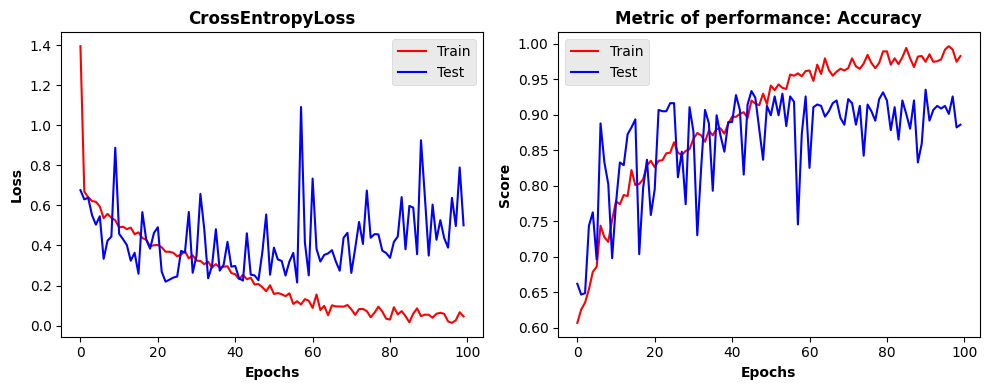

In [45]:
plot_loss_metric_curve(MODEL_RESULTS)

In [46]:
# Now we have to load the best model to make the predictions.
path = "/kaggle/working/topic_saved_weights.pt"
checkpoint = torch.load(path)
model_resnet_new = checkpoint.get("model")

In [47]:
# We make the predictions on the training and test set.

# We put the model in evaluation mode.
model_resnet_new.eval()

with torch.no_grad():
    # Training set predictions:
    y_pred_logits_train = model_resnet_new(X_train.to(device))
    y_pred_probs_train = torch.softmax(y_pred_logits_train.cpu(), dim = 1)
    y_pred_class_train = torch.argmax(y_pred_probs_train, dim = 1)
    
    # Test set predictions:
    y_pred_logits_test = model_resnet_new(X_test.to(device))
    y_pred_probs_test = torch.softmax(y_pred_logits_test.cpu(), dim = 1)
    y_pred_class_test = torch.argmax(y_pred_probs_test, dim = 1)

In [48]:
# We first transform our predictions into np.array's.
y_pred_train = y_pred_class_train.numpy()
y_pred_test = y_pred_class_test.numpy()

In [49]:
# Next, we transform our tags into np.array's.
y_train = y_train.numpy()
y_test = y_test.numpy()

# **5. Plot Metrics**

- **Confusion Matrix**

In [50]:
# We created our confusion matrices for both training and testing.
cf_mx_train = confusion_matrix(y_train, y_pred_train)
cf_mx_test = confusion_matrix(y_test, y_pred_test)

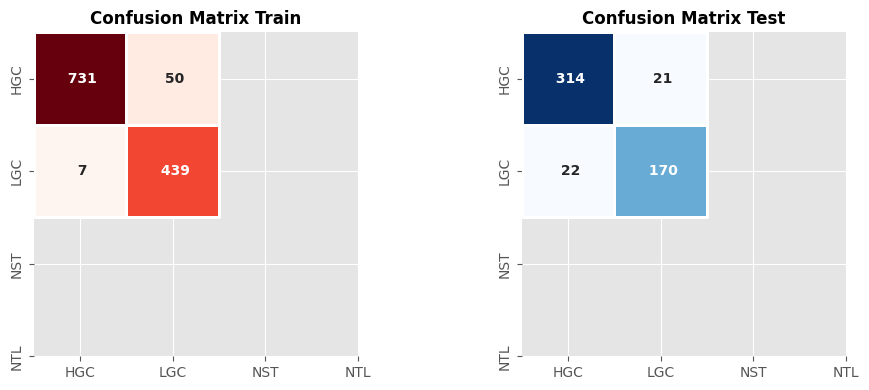

In [51]:
# We plotted the training and testing confusion matrix.
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
ax = ax.flat

sns.heatmap(cf_mx_train, 
            cmap = "Reds", 
            annot = True, 
            fmt = " ", 
            annot_kws = {"fontsize":10, "fontweight":"bold"},
            cbar = False, 
            linewidths = 1.0,
            square = True, 
            xticklabels = label_map,
            yticklabels = label_map,
            ax = ax[0],)
ax[0].set_title("Confusion Matrix Train", fontsize = 12, fontweight = "bold", color = "black")

sns.heatmap(cf_mx_test, 
            cmap = "Blues", 
            annot = True, 
            fmt = " ", 
            annot_kws = {"fontsize":10, "fontweight":"bold"},
            cbar = False, 
            linewidths = 1.0,
            square = True, 
            xticklabels = label_map, 
            yticklabels = label_map,
            ax = ax[1])
ax[1].set_title("Confusion Matrix Test", fontsize = 12, fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()

- **Classification Report**

In [52]:
print("**"*30)
print(" "*15, "Classification Report Train")
print("**"*30)
print(classification_report(y_train, y_pred_train),"\n")
print("**"*30)
print(" "*15, "Classification Report Test")
print("**"*30)
print(classification_report(y_test, y_pred_test))

************************************************************
                Classification Report Train
************************************************************
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       781
           1       0.90      0.98      0.94       446

    accuracy                           0.95      1227
   macro avg       0.94      0.96      0.95      1227
weighted avg       0.96      0.95      0.95      1227
 

************************************************************
                Classification Report Test
************************************************************
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       335
           1       0.89      0.89      0.89       192

    accuracy                           0.92       527
   macro avg       0.91      0.91      0.91       527
weighted avg       0.92      0.92      0.92       527

